In [12]:
%matplotlib inline

import numpy as np
from numpy.linalg import *

from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgetsa
from plot_helper import *

In [82]:
equal = np.allclose
v = lambda *c: np.array(c).reshape(-1, 1)
c = lambda *data: np.column_stack(data)
rm = lambda n, d, l=0: np.random.uniform(0+l, 1, size=n * d).reshape(-1, d)
printf = lambda *data, places=3 : print(np.round(data, places), "\n")
    
i = v(1,0)
j = v(0,1)

# Mathematics: Linear Algebra - Eigenvectors

* let's fill the 2D plane with a unit vector in (almost) every direction
    * ie., generate $\vec{r}_{...N}$ vectors around a circle, st. $||\vec{r}|| = 1$

In [83]:
N = 41
radians = np.linspace(0, 2*np.pi, N)

circle_x = np.cos(radians)
circle_y = np.sin(radians)

circle_r = [ v(x,y) for x, y in zip(circle_x, circle_y) ]

all([equal(norm(r), 1) for r in circle_r])

True

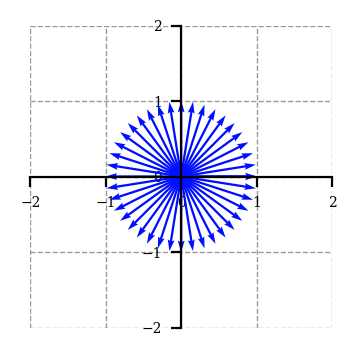

In [85]:
plot_vector(circle_r)

* Now let's investigate the effect of a linear transformation (matrix $C$) on "every" vector. 

In [5]:
C = c(j + 2*i, i + 2*j)
C

array([[2, 1],
       [1, 2]])

$\vec{r'_v} = Cr_v \quad \forall v..N$ 

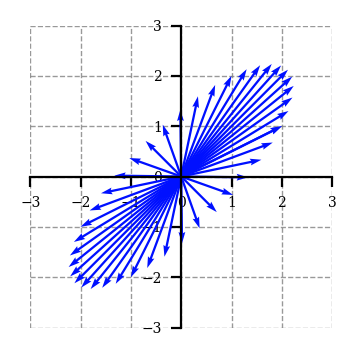

In [6]:
circle_rp = [C @ r for r in circle_r]
plot_vector(circle_rp)

* What vector was scaled the least?
* What vector was scaled the most?

* Let's find the shortest and longest prime vectors (ie., post-transformed)

In [7]:
len_rp = [np.linalg.norm(rp) for rp in circle_rp]
short_len, long_len = min(len_rp), max(len_rp)

In [8]:
short_len

1.0

In [9]:
long_len

3.0000000000000004

* So the minimum transformed vector was unchanged in its length (ie., still 1)
* The maximum was scaled $3*$

* Which vectors were these?

In [10]:
short_rp = circle_rp[len_rp.index(short_len)]
short_rp

array([[-0.70710678],
       [ 0.70710678]])

In [11]:
long_rp = circle_rp[len_rp.index(long_len)]
long_rp

array([[-2.12132034],
       [-2.12132034]])

* These vectors are quite interesting
* If you transform them with $C$, they do not change direction!
    * They only change length...
    
* So after applying $C$ you get *the same vector* (within a scaling factor)
* ie., 
    
    $C\vec{r_{s}} = \vec{r'_s} = \lambda_{s}\vec{r_{s}}$ 
    
    $C\vec{r_{l}} = \vec{r'_l} = \lambda_{l}\vec{r_{l}}$

* where $\lambda$ is just some constant scaling factor


* In general that,

$M\vec{v} = \lambda\vec{v}$

* `long_rp` is $\vec{r'_l}$, to get back $\vec{r_l}$ we just apply the inverse of $C$ .. ie., 

$\vec{r_l} = C^{-1}\vec{r'_l} = \frac{1}{\lambda_l}\vec{r'_l}$

* let's call this "untransformed" vector `eigen_long`

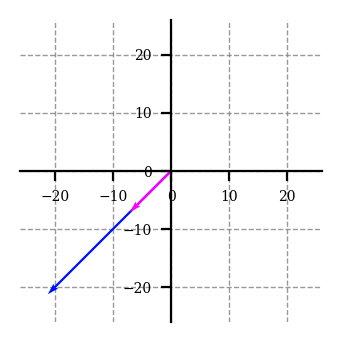

In [12]:
C_inv = inv(C)
eigen_long = C_inv @ long_rp
eigen_short = C_inv @ short_rp

plot_v(long_rp, eigen_long)

This is an eigenvector of $C$ ("characteristic vector"). Its direction is unchanged when transformed by $C$. 

ie., `eigen_long` is `C @ eigen_long` given some constant scaling factor:

In [13]:
equal(  long_len * eigen_long,     C @ eigen_long   )

True

In [14]:
equal(  short_len * eigen_short,   C @ eigen_short  )

True

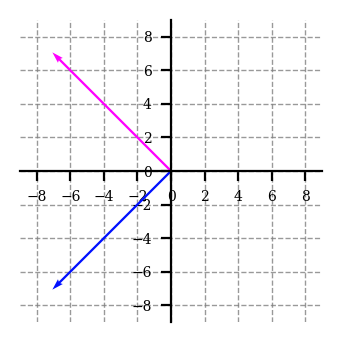

In [15]:
plot_v(eigen_long, eigen_short)

## Decomposition

It turns out you can reformulate a matrix in terms of its eigenvectors and eigenvalues. 

Recall the effect of $C$ on $r_{v..N}$

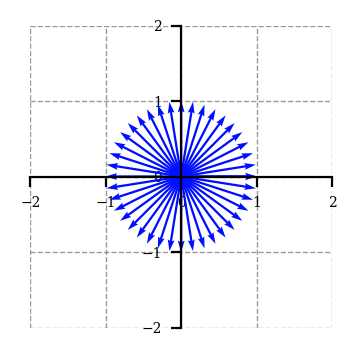

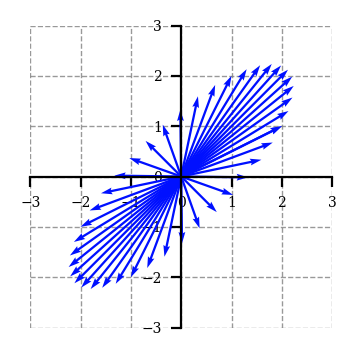

In [16]:
plot_vector(circle_r)
plot_vector(circle_rp)

Can we achive the same effect with a two matrices: a rotation and a scale?

Recall the maximal scaling effect was to increase by 3..

In [17]:
S = c(3*i, j)

And if we take $i$ to be the maximally scalled vector, it has also been rotated by $45 \deg$

In [18]:
angle = np.radians(45)

R_i = v(np.cos(angle), np.sin(angle))
R_j = v(-np.sin(angle), np.cos(angle))

R = c(R_i, R_j)

Let's try $R$ then $S$ on our unit circle $\vec{r_{v..N}}$

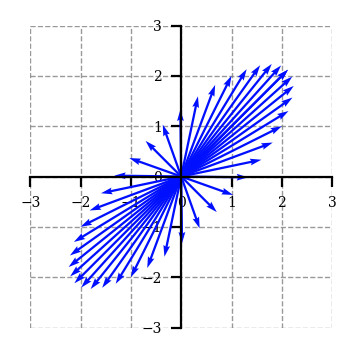

In [19]:
plot_vector(R @ S @ circle_r)

Wow! This *appears* to have worked precisely!

But that's odd.. because it *wasn't* $i$ that was maximally scaled by $3$... 

Let's check its the same by ensuring it keeps its eigenvectors pointing in the same direction.

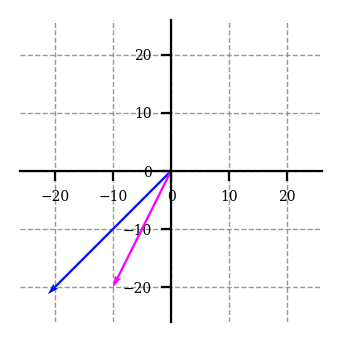

In [20]:
plot_v(C @ eigen_long, R @ S @ eigen_long )

Oh No! $RS$ is not equivalent to $C$. *Different* vectors are rotated and scaled, so that the global picture *looks* the same, but each individual vector is transformed differently.

It turns out $C$ is actually equivalent to $RSR^T$ 

where $R^T$ is $R$ transposed (rows/cols switched), which is a rotation matrix that "undoes" the rotation of R. Where R rotates $45 \deg$ right, $R^T$ does $45 \deg$ left.

$S$ then scales the basis vectors, and $R$ and $R^T$ handle orienting the space.

In [21]:
R @ S @ R.T

array([[2., 1.],
       [1., 2.]])

In [22]:
C

array([[2, 1],
       [1, 2]])

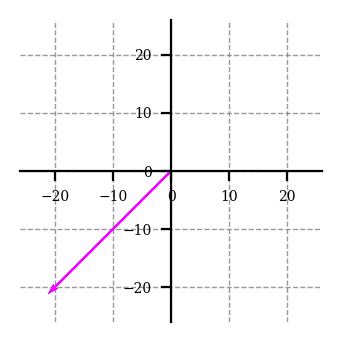

In [23]:
plot_v(C @ eigen_long, R @ S @ R.T @ eigen_long)

In [24]:
R

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [25]:
S

array([[3, 0],
       [0, 1]])

Since S only scales and $R$ *moves* the basis vectors (and all vectors), $R$ can be understood as a change of basis.

In which case the formula $RSR^T$ can be read as "change to R basis, scale in R, then change back to the original basis".

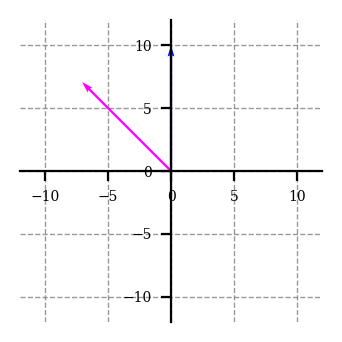

In [26]:
plot_v(j, R @ j)

## Low-Rank Approximations

There's lots of reasons to care about eigenvectors and eigenvalues -- but one important use is in data compression. 

The original matrix $C$ can be fully recovered from $R$ and $S$, with $S$ giving the *amounts* of each component of $R$. By reducing the size of $S$ we can get abitarily concise approximations to $C$. 

Let's illustrate this with a special case of $C$ where it *already* has more information that needed. Eg., consider the position of a 3D object described by it's relative position to 6 corners of a room -- this is 2x as much information that needed to precisely specify its position.

Matrices of these kind are known as "rank deficient" in that their rank (number of *independent* columns) is larger than the total number of columns present. 

Let's use numpy to calculate, as above, the eigenvalues and vectors of C:

In [40]:
(e_val_2, e_val_1), (e_vec_1, e_vec_2) = np.linalg.eig(C)

print(e_val_1, e_vec_1,  C @ e_vec_1)
print(e_val_2, e_vec_2,  C @ e_vec_2)

1.0 [ 0.70710678 -0.70710678] [ 0.70710678 -0.70710678]
3.0 [0.70710678 0.70710678] [2.12132034 2.12132034]


In [114]:
e_val, e_vec = np.linalg.eig(C)

R = e_vec
S = np.diag(e_val)

printf(S)
printf(R)

[[[3. 0.]
  [0. 1.]]]
[[[ 0.707 -0.707]
  [ 0.707  0.707]]]


In [115]:
C

array([[2, 1],
       [1, 2]])

In [117]:
R @ S @ R.T

array([[2., 1.],
       [1., 2.]])

In [119]:
printf(R @ S @ R.T @ v(1, 2))
printf(C @ v(1, 2))


[[[4.]
  [5.]]]
[[[4]
  [5]]]


And now for a rank-deficient matrix:

In [174]:
Li = v(1,2,1)
Lj = v(1,0,0)
Lk = 2 * Li

L = c(Li, Lj, Lk)

L

array([[1, 1, 2],
       [2, 0, 4],
       [1, 0, 2]])

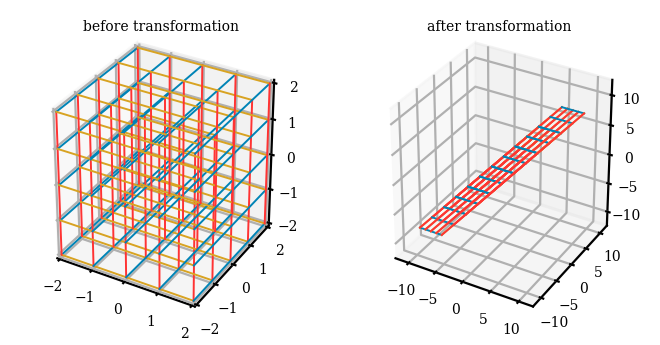

In [175]:
plot_3d_linear_transformation(L)

In [180]:
print('L:', matrix_rank(L), L.shape)
print('C:', matrix_rank(C), C.shape)

L: 2 (3, 3)
C: 2 (2, 2)


In [181]:
e_val, e_vec = np.linalg.eig(L)

R = e_vec
S = np.diag(e_val)

printf(S)
printf(R)

[[[ 3.562  0.     0.   ]
  [ 0.    -0.562  0.   ]
  [ 0.     0.     0.   ]]]
[[[ 0.573  0.753 -0.894]
  [ 0.733 -0.588 -0.   ]
  [ 0.367 -0.294  0.447]]]


$R^T$ becomes $R^{-1}$ in the general (non symetric) case..

In [182]:
printf(R @ S @ inv(R) @ v(1, 2, 3))
printf(L @ v(1, 2, 3))

[[[ 9.]
  [14.]
  [ 7.]]]
[[[ 9]
  [14]
  [ 7]]]


* Since two eigenvalues are zero, the two addition columns of R (ie., the final two eigenvectors) can be doing no work....

In [344]:
printf(L)
printf(R @ S @ inv(R))

[[[1 1 2]
  [2 0 4]
  [1 0 2]]] 

[[[ 1.  1.  2.]
  [ 2. -0.  4.]
  [ 1. -0.  2.]]] 



In [331]:
N = 2

R_red = R[:, 0:N]
S_red = np.diag(np.diag(S)[0:N])
R_red_inv = inv(R)[0:N, :]

In [332]:
L_full = R @ S @ inv(R)

In [333]:
L_lower = R_red @ S_red @ R_red_inv

* With `L_lower` we obtain the same result for transforming any vector as using $L$, despite only keeping $N$ dimensions. 

In [345]:
printf(L @ v(1, 2, 3))
printf(L_full @ v(1, 2, 3))
printf(L_lower @ v(1, 2, 3))

[[[ 9]
  [14]
  [ 7]]] 

[[[ 9.]
  [14.]
  [ 7.]]] 

[[[ 9.]
  [14.]
  [ 7.]]] 



## Singular Value Decomposition (SVD)

The above eigen-decomposition (into $C = RSR^T$) is only defined for square matrices (the eigenvalues in $S$, the eigenvectors in $R$). Only square matrices have eigenvalues. 

We can *make* a square matrix from $C$ by doing $C^TC$, then do an eigendecom on this.

Via this process we find *all* matrices decompose into 

$M = U \Sigma V^T$

A rotation, a strech and a rotation. The *same form*, but $\Sigma$ are now 'singular values' (alike eigenvalues). 

$U$ and $V^T$ are othogonal matrices, meaning that their columns are all orthogonal unit vectors; ie., these are 'pure rotations'. $\Sigma$ is a diagonal matix (with values only along the diagonal) whose effect is a *pure scaling*. 

Aside:
The second rotation $V^T$ is usually notated as a transpose of $V$, where $U$ and $V$ are othogonal. Libraries then return $V^T$ so you do not need to, in addition, transpose the final matrix.

In [1]:
from imageio import imread
image = imread('elephant-cc-wikimedia.jpg')[:, :, 0]

print(type(image))
print(image.shape)
print(image.dtype)

<class 'imageio.core.util.Array'>
(300, 300)
uint8


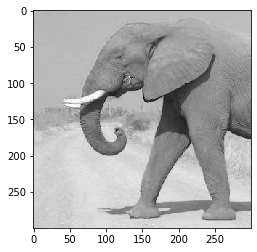

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(image, cmap="gray")

In [9]:
U, S, VT = np.linalg.svd(image)
print(U.shape, S.shape, VT.shape)

(300, 300) (300,) (300, 300)


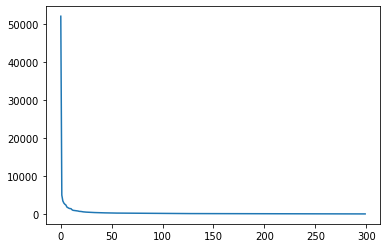

In [10]:
plt.plot(range(len(S)), S);

In [13]:
@interact(k=100)
def approximate(k):
    k = k if 0 < k < len(S) else 1
    u_k = U[:,:k]
    s_k = S[:k]
    vt_k = VT[:k,:]
    
    copy = numpy.round(u_k @ numpy.diag(s_k) @ vt_k)
    
    fig = pyplot.figure(figsize=(6,4))
    
    ax1 = pyplot.subplot(121)
    ax1.imshow(copy, cmap='gray')
    ax1.set_title('compressed'.format(k))
    
    
    ax2 = pyplot.subplot(122)
    ax2.imshow(image, cmap='gray')
    ax2.set_title('original'.format(k))
    
    ratio = image.size / (u_k.size + s_k.size + vt_k.size)

    fig.suptitle(f'$k = {k}$, compression ratio = {ratio:.1f}x')

interactive(children=(IntSlider(value=100, description='k', max=300, min=-100), Output()), _dom_classes=('widgâ€¦